In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import operator
from scipy import spatial
from math import log
from random import shuffle
from sklearn.model_selection import train_test_split
import string
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

In [2]:
movie_data = pd.read_csv('data/movies.csv')
# dropped = movie_data[movie_data.genres == '(no genres listed)']
# dropped = dropped[['movieId']].values
movie_data = movie_data[movie_data.genres != '(no genres listed)']
movie_id_list = movie_data[['movieId']].values
movies = movie_data['movieId'].unique().tolist()
print('Number of unique movies in the dataset: {}\n'.format(len(movies)))

genres = movie_data['genres'].unique().tolist()
unique_genres = set()
for genre_list in genres:
    sp = genre_list.split('|')
    for gen in sp:
        unique_genres.add(gen)
print('List of possible genres in the dataset:')
for genre in sorted(unique_genres)[:len(unique_genres)-1]:
    print(genre, end=', ')
print(sorted(unique_genres)[len(unique_genres)-1])
    
rating_data = pd.read_csv('data/ratings.csv')
rating_data = rating_data[rating_data.movieId.isin(movie_id_list)]
unique_users = rating_data['userId'].unique().tolist()
print('\n\nNumber of users in the dataset: {}'.format(len(unique_users)))
print('Number of ratings in the dataset: {}'.format(len(rating_data['userId'].tolist())))

Number of unique movies in the dataset: 53832

List of possible genres in the dataset:
Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western


Number of users in the dataset: 283220
Number of ratings in the dataset: 27735055


In [3]:
movie_categories = dict()

id_genres = movie_data[['movieId','genres']].values
for pair in id_genres:
    movie_categories[pair[0]] = pair[1].split('|')

rating_movies = rating_data[['movieId']].values
category_counts = defaultdict(int)
for movie in rating_movies:
    for cat in movie_categories[movie[0]]:
        category_counts[cat] += 1
category_counts_list = list(category_counts.items())
category_counts_list.sort(key=operator.itemgetter(1))
category_counts_list.reverse()
print('Top 5 most watched movie categories are:')
top_categories = []
for i in range(5):
    top_categories.append(category_counts_list[i][0])
    print('{}'.format(category_counts_list[i][0]))

Top 5 most watched movie categories are:
Drama
Comedy
Action
Thriller
Adventure


In [4]:
movie_tags = pd.read_csv('data/tags.csv')
movie_tags = movie_tags[movie_tags.movieId.isin(movie_id_list)]
movie_tags.drop(columns=['timestamp'],inplace=True)
movie_tags.drop_duplicates(inplace=True)

In [5]:
movie_tag_counts = defaultdict(list)
movie_tags_list = list(movie_tags[['movieId','tag']].values)
translator = str.maketrans('','',string.punctuation)
for pair in movie_tags_list:
    if isinstance(pair[1],str):
        for tag in (pair[1].translate(translator)).lower().split():
            movie_tag_counts[pair[0]].append(tag)


In [6]:
def get_defaultdict_int():
    return defaultdict(int)
def get_defaultdict_float():
    return defaultdict(float)
category_tags = defaultdict(get_defaultdict_int)
for movie in movie_tag_counts:
    for category in movie_categories[movie]:
        for tag in movie_tag_counts[movie]:
            category_tags[category][tag] += 1
category_totals = dict()
for category in category_tags:
    total = 0
    for tag in category_tags[category]:
        total += category_tags[category][tag]
    category_totals[category] = total

category_tf_scores = defaultdict(get_defaultdict_float)
for category in category_tags:
    for tag in category_tags[category]:
        category_tf_scores[category][tag] = category_tags[category][tag] / category_totals[category]
unique_tags = set()

for category in category_tf_scores:
    for tag in category_tf_scores[category]:
        unique_tags.add(tag)
tag_idf_scores = defaultdict(float)

for tag in list(unique_tags):
    doc_count = 0
    for category in category_tf_scores:
        if tag in category_tf_scores[category]:
            doc_count += 1
    tag_idf_scores[tag] = log(len(category_tf_scores)/doc_count)
    
tag_tfidf_scores = defaultdict(get_defaultdict_float)
for category in category_tags:
    for tag in list(unique_tags):
        tag_tfidf_scores[category][tag] = category_tf_scores[category][tag] * tag_idf_scores[tag]

for cat in top_categories:
    tags = list(tag_tfidf_scores[cat].items())
    tags.sort(key=operator.itemgetter(1))
    tags.reverse()
    print(cat)
    print(tags[:10])

Drama
[('tarantino', 0.0005313980353646588), ('leonardo', 0.00047551521625585174), ('dicaprio', 0.0004539401156997786), ('quentin', 0.0003754067496756724), ('austen', 0.00032373409988695494), ('coen', 0.0002902182366877576), ('gosling', 0.0002854745731082802), ('hanks', 0.00028518400286328276), ('pacino', 0.0002847708252445812), ('turing', 0.0002746138159434009)]
Comedy
[('standup', 0.0012291886139587668), ('pixar', 0.0007858312302732796), ('tarantino', 0.0005677095804373472), ('coen', 0.0005505858676349869), ('monty', 0.0005432770288008281), ('carell', 0.00043638911735652996), ('sandler', 0.0004259676671414713), ('quentin', 0.000372856860009544), ('wes', 0.0003563378851989946), ('aardman', 0.0003177782046419086)]
Action
[('tarantino', 0.0009066624124239697), ('marvel', 0.0009013881402910682), ('quentin', 0.0006596618932898785), ('007', 0.0005625692472049567), ('wars', 0.0005423368843254071), ('mcu', 0.00046991078295943435), ('space', 0.0004499276286524986), ('schwarzenegger', 0.000446

In [7]:
all_categories = [category[0] for category in category_counts_list]
check_words = set()
while len(check_words) < 2000:
    for cat in top_categories:
        tags = list(tag_tfidf_scores[cat].items())
        tags.sort(key=operator.itemgetter(1))
        tags.reverse()
        initial = len(check_words)
        i = 0
        while (len(check_words) - initial < 10):
            check_words.add(tags[i][0])
            i += 1
check_words = list(check_words)
print('Got words')
movie_tag_pairs = movie_tags[['movieId','tag']].values
shuffle(movie_tag_pairs)
train,test = train_test_split(movie_tag_pairs,shuffle=True)

Got words


In [8]:
def get_features(data,train=True):
    X = []
    y = []
    genre_list = []
    for datum in data:
        feature = []
        feature.append(1)
        movie_id = datum[0]
        tags = (str(datum[1]).translate(translator)).lower()
        for word in check_words:
            feature.append(word in tags)
        genres = movie_categories[movie_id]
        if not train:
            X.append(feature)
            genre_list.append(genres)
        for genre in genres:
            if train:
                X.append(feature)
            y.append(all_categories.index(genre))
    if train:
        return X,y
    else:
        return X,genre_list

X_train, y_train = get_features(train)
X_test, genres = get_features(test,False)

In [9]:
ovr = OneVsRestClassifier(LinearSVC())
ovr.fit(X_train,y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None)

In [10]:
correct = 0
predictions = ovr.predict(X_test)
for pred,genre_list in zip(predictions,genres):
    if all_categories[pred] in genre_list:
        correct += 1
print('Accuracy of tag SVM: {}'.format(correct/len(predictions)))

Accuracy of tag SVM: 0.5893116520930773


In [17]:
correct = 0
predictions = dict()
category_popularity = defaultdict(int)
for pair in train:
    cats = movie_categories[pair[0]]
    for cat in cats:
        category_popularity[all_categories.index(cat)] += 1
# for pair in movie_tag_pairs:
#     predictions[pair[0]] = top_categories[0]
genre_count_pairs = category_popularity.items()
check = sorted(genre_count_pairs,key=operator.itemgetter(1))
check.reverse()
for pair in test:
    predictions[pair[0]] = all_categories[check[0][0]]
for movie in predictions:
    if predictions[movie] in movie_categories[movie]:
        correct += 1
print('Accuracy of naive classifier: {}'.format(correct/len(predictions)))

Accuracy of naive classifier: 0.46096523603641604


In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import keras
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import *
import numpy as np

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [17]:
movie_year = dict()
for movie in movie_categories:
    s = str(movie_data[movie_data.movieId == movie]['title']).translate(translator)
    d = [int(s) for s in s.split() if s.isdigit()]
    if len(d) < 2:
        movie_year[movie] = 0
        continue
    movie_year[movie] = d[1]
def get_features(data,train=True):
    X = []
    y = []
    genre_list = []
    for datum in data:
        feature = []
        movie_id = datum[0]
        feature.append(1)
        #feature.append(movie_year[movie_id])
        tags = (str(datum[1]).translate(translator)).lower()
        for word in check_words:
            feature.append(word in tags)
        genres = movie_categories[movie_id]
        if not train:
            X.append(feature)
            genre_list.append(genres)
        for genre in genres:
            if train:
                X.append(feature)
            y.append(all_categories.index(genre))
    if train:
        return X,y
    else:
        return X,genre_list
    
X_train, y_train = get_features(train,False)

y = np.zeros((len(y_train),len(all_categories)))
index = 0

for cats in y_train:
    feat = [0] * len(all_categories)
    for cat in cats:
        feat[all_categories.index(cat)] = 1
    y[index] = feat
    index += 1
X = np.asarray(X_train)

In [18]:
X_, y_ = get_features(test,False)
X_test = np.asarray(X_)

In [11]:
def generate_model(X, y, params):
    model = Sequential()
    model.add(Dense(params['layer1'], activation=params['activation'], input_dim=X.shape[1]))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['layer2'], activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(y.shape[1], activation='sigmoid'))
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['categorical_accuracy'])

    model.fit(X, y, epochs=params['epochs'], batch_size=params['batch_size'])
    
    preds = model.predict(X_test)
    correct = 0
    index = 0
    for real in y_:
        if all_categories[np.argmax(preds[index])] in real:
            correct += 1
        index += 1
    print('Accuracy: {}'.format(correct/len(y_)))
    return model,(correct/len(y_))

In [77]:
optimizers = [Nadam(),RMSprop(),SGD()]
layer1 = [500,700,1000,1500]
layer2 = [300,400,800]
loss = ['logcosh','binary_crossentropy']
activation = ['relu', 'elu']
epochs = [1,2,3,4]
dropout = [0.1,0.5,0.9]
batch_size = [2000,10000]

In [82]:
results = []
for opt in optimizers:
    for l1 in layer1:
        for l2 in layer2:
            for ls in loss:
                for act in activation:
                    for ep in epochs:
                        for drop in dropout:
                            for batch in batch_size:
                                param = {'optimizer':opt,
                                 'layer1':l1,
                                 'layer2':l2,
                                 'loss':ls,
                                 'activation':act,
                                 'epochs':ep,
                                 'dropout':drop,
                                 'batch_size':batch}
                                model, acc = generate_model(X,y,param)
                                results.append((model,acc,param))

Epoch 1/1
826149/826149 [==============================] - 5s 6us/step - loss: 0.0446 - categorical_accuracy: 0.4910
Accuracy: 0.5898091392383
Epoch 1/1
826149/826149 [==============================] - 4s 5us/step - loss: 0.0480 - categorical_accuracy: 0.4878
Accuracy: 0.5859345495744125
Epoch 1/1
826149/826149 [==============================] - 5s 7us/step - loss: 0.0452 - categorical_accuracy: 0.4928
Accuracy: 0.5884038288353717
Epoch 1/1
826149/826149 [==============================] - 4s 5us/step - loss: 0.0481 - categorical_accuracy: 0.4858
Accuracy: 0.5825610783487785
Epoch 1/1
826149/826149 [==============================] - 6s 7us/step - loss: 0.0479 - categorical_accuracy: 0.4867
Accuracy: 0.5473121168985853
Epoch 1/1
826149/826149 [==============================] - 5s 5us/step - loss: 0.0499 - categorical_accuracy: 0.4796
Accuracy: 0.5357972866978473
Epoch 1/2
826149/826149 [==============================] - 6s 7us/step - loss: 0.0446 - categorical_accuracy: 0.4919
Epoch 2/2


826149/826149 [==============================] - 6s 8us/step - loss: 0.0482 - categorical_accuracy: 0.4755
Accuracy: 0.5874052232518955
Epoch 1/1
826149/826149 [==============================] - 8s 10us/step - loss: 0.0489 - categorical_accuracy: 0.4813
Accuracy: 0.5679814368300264
Epoch 1/1
826149/826149 [==============================] - 7s 8us/step - loss: 0.0521 - categorical_accuracy: 0.4673
Accuracy: 0.5545383900299219
Epoch 1/2
826149/826149 [==============================] - 8s 10us/step - loss: 0.0464 - categorical_accuracy: 0.4888
Epoch 2/2
826149/826149 [==============================] - 4s 4us/step - loss: 0.0435 - categorical_accuracy: 0.4903
Accuracy: 0.5888177962408855
Epoch 1/2
826149/826149 [==============================] - 7s 8us/step - loss: 0.0548 - categorical_accuracy: 0.4693
Epoch 2/2
826149/826149 [==============================] - 2s 3us/step - loss: 0.0503 - categorical_accuracy: 0.4866
Accuracy: 0.5802661011532987
Epoch 1/2
826149/826149 [===================

Epoch 1/2
826149/826149 [==============================] - 12s 14us/step - loss: 0.3186 - categorical_accuracy: 0.4912
Epoch 2/2
826149/826149 [==============================] - 4s 5us/step - loss: 0.3124 - categorical_accuracy: 0.4917
Accuracy: 0.5901904250065363
Epoch 1/2
826149/826149 [==============================] - 10s 12us/step - loss: 0.3325 - categorical_accuracy: 0.4903
Epoch 2/2
826149/826149 [==============================] - 2s 3us/step - loss: 0.3136 - categorical_accuracy: 0.4920
Accuracy: 0.590484559742033
Epoch 1/2
826149/826149 [==============================] - 12s 14us/step - loss: 0.3255 - categorical_accuracy: 0.4915
Epoch 2/2
826149/826149 [==============================] - 4s 5us/step - loss: 0.3185 - categorical_accuracy: 0.4923
Accuracy: 0.5890284112366732
Epoch 1/2
826149/826149 [==============================] - 10s 12us/step - loss: 0.3391 - categorical_accuracy: 0.4848
Epoch 2/2
826149/826149 [==============================] - 2s 3us/step - loss: 0.3205 -

826149/826149 [==============================] - 2s 3us/step - loss: 0.3130 - categorical_accuracy: 0.4900
Accuracy: 0.5892898643348924
Epoch 1/2
826149/826149 [==============================] - 15s 18us/step - loss: 0.3220 - categorical_accuracy: 0.4863
Epoch 2/2
826149/826149 [==============================] - 4s 5us/step - loss: 0.3165 - categorical_accuracy: 0.4893
Accuracy: 0.5888758969293786
Epoch 1/2
826149/826149 [==============================] - 13s 16us/step - loss: 0.3331 - categorical_accuracy: 0.4758
Epoch 2/2
826149/826149 [==============================] - 2s 3us/step - loss: 0.3166 - categorical_accuracy: 0.4895
Accuracy: 0.5893515963164163
Epoch 1/2
826149/826149 [==============================] - 15s 19us/step - loss: 0.3469 - categorical_accuracy: 0.4750
Epoch 2/2
826149/826149 [==============================] - 4s 5us/step - loss: 0.3344 - categorical_accuracy: 0.4867
Accuracy: 0.5689437294831944
Epoch 1/2
826149/826149 [==============================] - 14s 17us/s

826149/826149 [==============================] - 17s 20us/step - loss: 0.0499 - categorical_accuracy: 0.4852
Epoch 2/2
826149/826149 [==============================] - 2s 3us/step - loss: 0.0446 - categorical_accuracy: 0.4982
Accuracy: 0.5874742178194812
Epoch 1/2
826149/826149 [==============================] - 18s 22us/step - loss: 0.0483 - categorical_accuracy: 0.4860
Epoch 2/2
826149/826149 [==============================] - 4s 5us/step - loss: 0.0467 - categorical_accuracy: 0.4924
Accuracy: 0.5513501147488598
Epoch 1/2
826149/826149 [==============================] - 17s 20us/step - loss: 0.0523 - categorical_accuracy: 0.4806
Epoch 2/2
826149/826149 [==============================] - 2s 3us/step - loss: 0.0473 - categorical_accuracy: 0.4890
Accuracy: 0.5578065537576621
Epoch 1/3
826149/826149 [==============================] - 19s 23us/step - loss: 0.0455 - categorical_accuracy: 0.4970
Epoch 2/3
826149/826149 [==============================] - 4s 5us/step - loss: 0.0434 - categori

826149/826149 [==============================] - 4s 5us/step - loss: 0.0468 - categorical_accuracy: 0.4902
Accuracy: 0.5757778229672021
Epoch 1/2
826149/826149 [==============================] - 20s 25us/step - loss: 0.0525 - categorical_accuracy: 0.4700
Epoch 2/2
826149/826149 [==============================] - 2s 3us/step - loss: 0.0478 - categorical_accuracy: 0.4949
Accuracy: 0.5702873079045987
Epoch 1/3
826149/826149 [==============================] - 22s 27us/step - loss: 0.0482 - categorical_accuracy: 0.4861
Epoch 2/3
826149/826149 [==============================] - 4s 5us/step - loss: 0.0435 - categorical_accuracy: 0.4897
Epoch 3/3
826149/826149 [==============================] - 4s 5us/step - loss: 0.0434 - categorical_accuracy: 0.4909
Accuracy: 0.5893225459721698
Epoch 1/3
826149/826149 [==============================] - 21s 25us/step - loss: 0.0540 - categorical_accuracy: 0.4746
Epoch 2/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.0481 - categorica

826149/826149 [==============================] - 26s 32us/step - loss: 0.3181 - categorical_accuracy: 0.4908
Epoch 2/3
826149/826149 [==============================] - 4s 5us/step - loss: 0.3122 - categorical_accuracy: 0.4913
Epoch 3/3
826149/826149 [==============================] - 4s 5us/step - loss: 0.3115 - categorical_accuracy: 0.4917
Accuracy: 0.5915921041164338
Epoch 1/3
826149/826149 [==============================] - 24s 29us/step - loss: 0.3319 - categorical_accuracy: 0.4905
Epoch 2/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.3132 - categorical_accuracy: 0.4915
Epoch 3/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.3121 - categorical_accuracy: 0.4918
Accuracy: 0.5913887517067077
Epoch 1/3
826149/826149 [==============================] - 26s 32us/step - loss: 0.3247 - categorical_accuracy: 0.4907
Epoch 2/3
826149/826149 [==============================] - 4s 5us/step - loss: 0.3179 - categorical_accuracy: 0.4924
Epoch 3/3


826149/826149 [==============================] - 28s 33us/step - loss: 0.3280 - categorical_accuracy: 0.4826
Epoch 2/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.3129 - categorical_accuracy: 0.4902
Epoch 3/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.3123 - categorical_accuracy: 0.4909
Accuracy: 0.5890610928739506
Epoch 1/3
826149/826149 [==============================] - 30s 36us/step - loss: 0.3215 - categorical_accuracy: 0.4848
Epoch 2/3
826149/826149 [==============================] - 5s 5us/step - loss: 0.3160 - categorical_accuracy: 0.4891
Epoch 3/3
826149/826149 [==============================] - 5s 6us/step - loss: 0.3154 - categorical_accuracy: 0.4893
Accuracy: 0.5886652819335909
Epoch 1/3
826149/826149 [==============================] - 28s 34us/step - loss: 0.3319 - categorical_accuracy: 0.4819
Epoch 2/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.3160 - categorical_accuracy: 0.4896
Epoch 3/3


826149/826149 [==============================] - 34s 41us/step - loss: 0.0455 - categorical_accuracy: 0.4925
Epoch 2/3
826149/826149 [==============================] - 5s 6us/step - loss: 0.0439 - categorical_accuracy: 0.4936
Epoch 3/3
826149/826149 [==============================] - 5s 6us/step - loss: 0.0437 - categorical_accuracy: 0.4932
Accuracy: 0.5907423815472214
Epoch 1/3
826149/826149 [==============================] - 32s 39us/step - loss: 0.0506 - categorical_accuracy: 0.4848
Epoch 2/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.0447 - categorical_accuracy: 0.4972
Epoch 3/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.0441 - categorical_accuracy: 0.4956
Accuracy: 0.5888904221015019
Epoch 1/3
826149/826149 [==============================] - 34s 42us/step - loss: 0.0478 - categorical_accuracy: 0.4912
Epoch 2/3
826149/826149 [==============================] - 5s 6us/step - loss: 0.0464 - categorical_accuracy: 0.4990
Epoch 3/3


826149/826149 [==============================] - 36s 43us/step - loss: 0.0538 - categorical_accuracy: 0.4762
Epoch 2/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.0472 - categorical_accuracy: 0.4858
Epoch 3/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.0439 - categorical_accuracy: 0.4906
Accuracy: 0.5883094152165703
Epoch 1/3
826149/826149 [==============================] - 38s 47us/step - loss: 0.0497 - categorical_accuracy: 0.4689
Epoch 2/3
826149/826149 [==============================] - 5s 6us/step - loss: 0.0475 - categorical_accuracy: 0.4839
Epoch 3/3
826149/826149 [==============================] - 5s 6us/step - loss: 0.0471 - categorical_accuracy: 0.4833
Accuracy: 0.5809923597594632
Epoch 1/3
826149/826149 [==============================] - 36s 44us/step - loss: 0.0514 - categorical_accuracy: 0.4683
Epoch 2/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.0474 - categorical_accuracy: 0.4921
Epoch 3/3


826149/826149 [==============================] - 43s 52us/step - loss: 0.3439 - categorical_accuracy: 0.4877
Epoch 2/3
826149/826149 [==============================] - 5s 6us/step - loss: 0.3373 - categorical_accuracy: 0.4913
Epoch 3/3
826149/826149 [==============================] - 5s 6us/step - loss: 0.3356 - categorical_accuracy: 0.4924
Accuracy: 0.5535869912558464
Epoch 1/3
826149/826149 [==============================] - 40s 49us/step - loss: 0.3524 - categorical_accuracy: 0.4814
Epoch 2/3
826149/826149 [==============================] - 3s 3us/step - loss: 0.3369 - categorical_accuracy: 0.4904
Epoch 3/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.3354 - categorical_accuracy: 0.4924
Accuracy: 0.5650037765447521
Epoch 1/4
826149/826149 [==============================] - 43s 52us/step - loss: 0.3182 - categorical_accuracy: 0.4912
Epoch 2/4
826149/826149 [==============================] - 5s 6us/step - loss: 0.3119 - categorical_accuracy: 0.4923
Epoch 3/4


826149/826149 [==============================] - 45s 55us/step - loss: 0.3508 - categorical_accuracy: 0.4669
Epoch 2/3
826149/826149 [==============================] - 3s 3us/step - loss: 0.3301 - categorical_accuracy: 0.4894
Epoch 3/3
826149/826149 [==============================] - 2s 3us/step - loss: 0.3280 - categorical_accuracy: 0.4905
Accuracy: 0.5853353862243268
Epoch 1/4
826149/826149 [==============================] - 48s 58us/step - loss: 0.3178 - categorical_accuracy: 0.4864
Epoch 2/4
826149/826149 [==============================] - 5s 7us/step - loss: 0.3129 - categorical_accuracy: 0.4898
Epoch 3/4
826149/826149 [==============================] - 5s 7us/step - loss: 0.3125 - categorical_accuracy: 0.4903
Epoch 4/4
826149/826149 [==============================] - 5s 7us/step - loss: 0.3123 - categorical_accuracy: 0.4904
Accuracy: 0.5884474043517416
Epoch 1/4
826149/826149 [==============================] - 45s 55us/step - loss: 0.3308 - categorical_accuracy: 0.4807
Epoch 2/4


826149/826149 [==============================] - 53s 64us/step - loss: 0.0454 - categorical_accuracy: 0.4957
Epoch 2/4
826149/826149 [==============================] - 5s 7us/step - loss: 0.0434 - categorical_accuracy: 0.4924
Epoch 3/4
826149/826149 [==============================] - 5s 7us/step - loss: 0.0433 - categorical_accuracy: 0.4927
Epoch 4/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.0433 - categorical_accuracy: 0.4930
Accuracy: 0.5911817680039508
Epoch 1/4
826149/826149 [==============================] - 55s 67us/step - loss: 0.0505 - categorical_accuracy: 0.4939: 1:16 - loss: 0.
Epoch 2/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.0446 - categorical_accuracy: 0.4993
Epoch 3/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.0436 - categorical_accuracy: 0.4952
Epoch 4/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.0435 - categorical_accuracy: 0.4932
Accuracy: 0.591007465938

826149/826149 [==============================] - 6s 7us/step - loss: 0.0434 - categorical_accuracy: 0.4908
Accuracy: 0.5893879092467246
Epoch 1/4
826149/826149 [==============================] - 54s 66us/step - loss: 0.0546 - categorical_accuracy: 0.4718
Epoch 2/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.0475 - categorical_accuracy: 0.4988
Epoch 3/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.0439 - categorical_accuracy: 0.4909
Epoch 4/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.0436 - categorical_accuracy: 0.4902
Accuracy: 0.588581762193882
Epoch 1/4
826149/826149 [==============================] - 57s 69us/step - loss: 0.0453 - categorical_accuracy: 0.4845
Epoch 2/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.0439 - categorical_accuracy: 0.4881
Epoch 3/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.0438 - categorical_accuracy: 0.4884
Epoch 4/4
826

826149/826149 [==============================] - 3s 3us/step - loss: 0.3122 - categorical_accuracy: 0.4921
Epoch 4/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.3117 - categorical_accuracy: 0.4920
Accuracy: 0.5913705952415537
Epoch 1/4
826149/826149 [==============================] - 62s 75us/step - loss: 0.3243 - categorical_accuracy: 0.4906
Epoch 2/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.3179 - categorical_accuracy: 0.4923
Epoch 3/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.3169 - categorical_accuracy: 0.4927
Epoch 4/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.3164 - categorical_accuracy: 0.4924
Accuracy: 0.590873108096331
Epoch 1/4
826149/826149 [==============================] - 59s 71us/step - loss: 0.3381 - categorical_accuracy: 0.4853: 8s - loss: 0.3405 - categorical_accur
Epoch 2/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.3200 - cat

826149/826149 [==============================] - 67s 81us/step - loss: 0.3220 - categorical_accuracy: 0.4849
Epoch 2/4
826149/826149 [==============================] - 6s 8us/step - loss: 0.3164 - categorical_accuracy: 0.4891
Epoch 3/4
826149/826149 [==============================] - 6s 8us/step - loss: 0.3157 - categorical_accuracy: 0.4896
Epoch 4/4
826149/826149 [==============================] - 6s 8us/step - loss: 0.3154 - categorical_accuracy: 0.4894
Accuracy: 0.5889194724457485
Epoch 1/4
826149/826149 [==============================] - 64s 77us/step - loss: 0.3329 - categorical_accuracy: 0.4755
Epoch 2/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.3165 - categorical_accuracy: 0.4891
Epoch 3/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.3158 - categorical_accuracy: 0.4896
Epoch 4/4
826149/826149 [==============================] - 3s 3us/step - loss: 0.3154 - categorical_accuracy: 0.4900
Accuracy: 0.5895549487261424
Epoch 1/4
82

KeyboardInterrupt: 

In [86]:
max(results,key=operator.itemgetter(1))

(<keras.engine.sequential.Sequential at 0x7fa53eef3908>,
 0.5918789762658687,
 {'optimizer': <keras.optimizers.Nadam at 0x7fa8a49ce518>,
  'layer1': 500,
  'layer2': 400,
  'loss': 'binary_crossentropy',
  'activation': 'relu',
  'epochs': 4,
  'dropout': 0.1,
  'batch_size': 10000})

In [12]:
from keras import backend as K


In [19]:
K.clear_session()
model, _= generate_model(X,y,{'optimizer':Adam(),'layer1':1500,'layer2':800,'loss':'binary_crossentropy',
                             'activation':'relu','epochs':4,'dropout':0.3,'batch_size':10000})

Epoch 1/4
826149/826149 [==============================] - 12s 15us/step - loss: 0.3625 - categorical_accuracy: 0.4845
Epoch 2/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.3139 - categorical_accuracy: 0.4949
Epoch 3/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.3077 - categorical_accuracy: 0.4906
Epoch 4/4
826149/826149 [==============================] - 6s 7us/step - loss: 0.3054 - categorical_accuracy: 0.4889
Accuracy: 0.6136413153995874


In [11]:
id_genres

array([[1, 'Adventure|Animation|Children|Comedy|Fantasy'],
       [2, 'Adventure|Children|Fantasy'],
       [3, 'Comedy|Romance'],
       ...,
       [193880, 'Drama'],
       [193882, 'Adventure|Drama|Horror|Sci-Fi'],
       [193886, 'Action|Crime|Drama']], dtype=object)

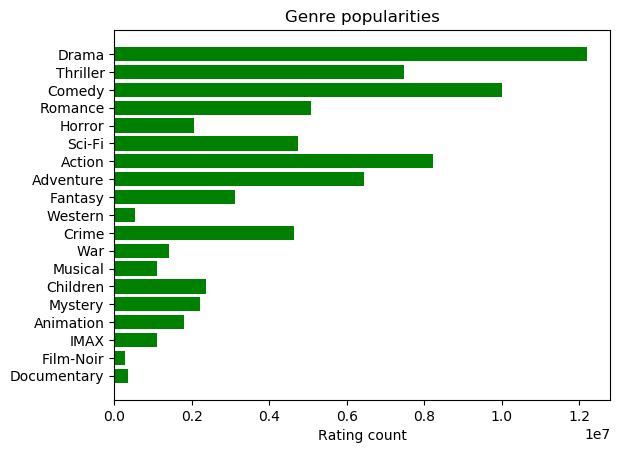

In [24]:
genres = []
performance = []
for genre in category_counts:
    genres.append(genre)
    performance.append(category_counts[genre])
error = np.random.rand(len(genres))
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(genres))
ax.barh(y_pos, performance, xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(genres)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Rating count')
ax.set_title('Genre popularities')

plt.show()